<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Training_optic_Discs_in_Efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection

Kaggle has a large competition of Diabetic Retinopathy detection which can be found here:
https://www.kaggle.com/c/diabetic-retinopathy-detection/

Their dataset consists in 35126 images labeled from 0 to 4 according to the degree of Retinopathy.
An analysis of the data is provided in this notebook.

In [ ]:
!rm -rf sample_data
!nvidia-smi

Fri Feb 19 14:04:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies

In [30]:
from IPython.display import clear_output

!pip install torch==1.7.1+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install efficientnet_pytorch
clear_output(wait=False)

## Load data from local drive


In [ ]:
!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ETdcB8GscyBAkhUFvNMzpoUBLLgg7ej9Q3t4rK_bR8ngSA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait=False)
print("Data Downloaded")

Data Downloaded


In [17]:
!rm checkpoint*

In [1]:
import pandas as pd
import os

Bad =  pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Neovessels",File) for File in os.listdir("./OpticDiscs/Neovessels") if ".jpeg" in File]})
Good = pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Good images",File) for File in os.listdir("./OpticDiscs/Good images") if ".jpeg" in File]}).sample(len(Bad),random_state = 42)

data = pd.concat((Good,Bad),axis = 0)
data.head()
data['class'] = data['imageFilename'].apply(lambda x : 1 if "Good" in x else 0)
data = data.reset_index()
data = data[['imageFilename','class']]
data.head()

,imageFilename,class
0,./OpticDiscs/Good images/4270_left.jpeg,1
1,./OpticDiscs/Good images/26079_left.jpeg,1
2,./OpticDiscs/Good images/4998_right.jpeg,1
3,./OpticDiscs/Good images/21026_right.jpeg,1
4,./OpticDiscs/Good images/40631_left.jpeg,1


In [2]:
len(data)

374

#### Split data

In [3]:
from sklearn.model_selection import train_test_split

Train,Validation = train_test_split(data,test_size = 0.40,random_state = 65)
X_train = Train['imageFilename']
y_train = Train['class']
#Split data
X_validation, X_test, y_validation, y_test = train_test_split(Validation['imageFilename'], Validation['class'], test_size=0.50, random_state=65)


In [4]:
print("Datos de entrenamiento:")
print(y_train.value_counts())
print("Datos de validación:")
print(y_validation.value_counts())
print("Datos de test:")
print(y_test.value_counts())

Datos de entrenamiento:
0    119
1    105
Name: class, dtype: int64
Datos de validación:
1    44
0    31
Name: class, dtype: int64
Datos de test:
1    38
0    37
Name: class, dtype: int64


In [5]:
test_data = pd.DataFrame({'image':X_test,'class':y_test})
test_data['image'] = test_data['image'].apply(lambda x : x.split('/')[-1])
test_data.head()

,image,class
198,37829_left.jpeg,0
9,29712_left.jpeg,1
132,32085_right.jpeg,1
259,11896_left.jpeg,0
208,21096_left.jpeg,0


In [6]:
test_data.to_csv('test_data.csv',index=False)

## Definition of the model

In [7]:
from efficientnet_pytorch import EfficientNet
import torch
network_name = 'efficientnet-b7'
model = EfficientNet.from_pretrained(network_name)

Loaded pretrained weights for efficientnet-b7


In [8]:
model._fc

Linear(in_features=2560, out_features=1000, bias=True)

In [9]:
## Change efficientnet final layer
model._fc = torch.nn.Linear(in_features=2560,out_features=2,bias = True)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

63792082

In [11]:
from torchvision.transforms import Resize,ToTensor,Compose,Normalize
from torchvision.transforms import RandomHorizontalFlip,RandomVerticalFlip,RandomRotation,ColorJitter,RandomResizedCrop,RandomPerspective,GaussianBlur
from PIL import Image

transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),
                      RandomRotation(180),ColorJitter(0.5,0.5,0.5),
                      RandomResizedCrop((600,600), scale=(0.7, 1.2)),
                      RandomPerspective(),
                      GaussianBlur((3,3))]) # Transformations for the training images

composed = Compose([Resize(600), # Resize to a fit size for efficientnet
                    ToTensor(),  # Convert into sensor
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize image

### Training parameters

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
seed = 17
torch.manual_seed(seed)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

In [14]:
try:
    model = torch.load('./checkpoint_efficientnet-b7_12_0.89333.ph', map_location=device)
except:
    print("No Checkpoint loaded")

In [16]:
classes = {0:[0,0,0,0,1],
           1:[0,0,0,1,0],
           2:[0,0,1,0,0],
           3:[0,1,0,0,0],
           4:[1,0,0,0,0]}

In [17]:
from tqdm import tqdm
import random
random.seed(seed)

epochs = 80
batch_size = 1  # I will use batch size of 1 to keep the ratio of each image

TRAINING_acc = []
VALIDATION_acc = []
BEST_val_acc = 0.0

for epoch in range(epochs):
    
    indexes = [idx for idx in range(len(X_train))]
    pbar = tqdm( range(len(X_train)//batch_size),ncols = 100)
    running_loss = 0.0
    running_acc = 0.0
    t = 0

    for step in pbar:
        # Load data
        idx = random.sample(indexes,batch_size)
        X = X_train.iloc[idx]
        y = y_train.iloc[idx]

        # Remove indexes
        [indexes.remove(i) for i in idx]

        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = transforms(image)
            P = composed(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += batch_size

        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == y_true).cpu().detach().numpy()
        acc = torch.sum(preds == y_true).cpu().detach().numpy()/batch_size;
        pbar.set_description("Epoch: {} Accuracy: {:0.5f} Loss: {:0.5f} ".format(epoch+1,running_acc/t,loss.item()))
    #Validation
    TRAINING_acc.append(running_acc/t)
    val_acc = 0.0
    val_loss = 0.0
    t = 0
    for point in range(len(X_validation)//batch_size):
        with torch.no_grad():

            X = X_validation.iloc[point*batch_size:(point+1)*batch_size]
            y = y_validation.iloc[point*batch_size:(point+1)*batch_size]


            # Load images
            try:
                images = [Image.open(File) for File in X]
            except:
                continue
            # Load y_true
            y_true = torch.LongTensor([c for c in y]).to(device)
            
            # Convert images to tensor
            x_batch = torch.FloatTensor().to(device)
            for image in images:
                P = composed(image).unsqueeze(0).to(device)
                x_batch = torch.cat((x_batch,P))

            
            outputs = model(x_batch)
            loss = criterion(outputs, y_true)
            val_loss += loss.item()
            t += batch_size
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == y_true).cpu().detach().numpy()
    VALIDATION_acc.append(val_acc/t)
    print("Validation -- Accuracy: {:0.5f} Loss: {:0.5f} \n".format(val_acc/t,loss.item()))
    if val_acc/t > BEST_val_acc:
        try:
            torch.save(model,"/content/checkpoint_{}_{}_{:0.5f}.ph".format(network_name,epoch+1,val_acc/t))
            BEST_val_acc = val_acc/t
        except:
            continue

Epoch: 1 Accuracy: 0.91518 Loss: 0.06654 : 100%|██████████████████| 224/224 [02:04<00:00,  1.80it/s]


Validation -- Accuracy: 0.86667 Loss: 0.07141 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84000 Loss: 0.14195 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.81333 Loss: 0.06557 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84000 Loss: 0.05273 



Epoch: 5 Accuracy: 0.95982 Loss: 0.98572 : 100%|██████████████████| 224/224 [02:04<00:00,  1.79it/s]


Validation -- Accuracy: 0.89333 Loss: 0.18445 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84000 Loss: 0.15982 



  0%|                                                                       | 0/224 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84000 Loss: 0.17255 



Epoch: 8 Accuracy: 0.99219 Loss: 0.03605 :  57%|██████████▎       | 128/224 [01:11<00:53,  1.80it/s]

KeyboardInterrupt: ignored

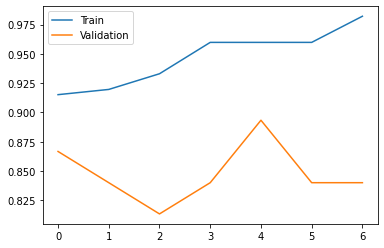

In [18]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

In [ ]:
!ls

checkpoint_efficientnet-b7_1_0.60000.ph
checkpoint_efficientnet-b7_12_0.90667.ph
checkpoint_efficientnet-b7_15_0.92000.ph
checkpoint_efficientnet-b7_4_0.74667.ph
checkpoint_efficientnet-b7_44_0.93333.ph
checkpoint_efficientnet-b7_5_0.77333.ph
checkpoint_efficientnet-b7_6_0.80000.ph
checkpoint_efficientnet-b7_7_0.82667.ph
checkpoint_efficientnet-b7_8_0.88000.ph
OpticDiscs
test_data.csv


In [ ]:
torch.save(model,"checkpoint.ph")

In [ ]:
for c in y:
  print(c)

1


## Evaluation

In [19]:
model = torch.load('checkpoint_efficientnet-b7_5_0.89333.ph')

In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [21]:
predicted = []
true_values = []
all_predicted = []
all_true = []
for point in range(len(X_test)//batch_size):
    with torch.no_grad():

        X = X_test.iloc[point*batch_size:(point+1)*batch_size]
        y = y_test.iloc[point*batch_size:(point+1)*batch_size]

        true_values.append(y.values)
        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = composed(image).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        all_predicted.append(outputs.cpu().detach().numpy()[0][1])
        all_true.append(y_true.cpu().detach().numpy()[0])
        
        _, preds = torch.max(outputs, 1)
        predicted.append(preds)

In [22]:
true_values = np.array(true_values).reshape(-1)
dummy = torch.FloatTensor().to(device)
for tensor in predicted:
    dummy = torch.cat((dummy,tensor))
predicted = dummy.view(-1).cpu().numpy()

In [23]:
confusion_matrix(true_values, predicted)

array([[33,  4],
       [ 7, 31]])

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

ns_fpr, ns_tpr, _ = roc_curve(all_true, all_predicted)
plt.plot(ns_fpr,ns_tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
print(roc_auc_score(all_true, all_predicted))

tensor([[ 1.2768, -1.3801]], device='cuda:0')

In [ ]:
!mkdir Results
roc_data = pd.DataFrame(data = {"ns_fpr":ns_fpr,"ns_tpr":ns_tpr})
roc_data.to_csv("./Results/"+network_name+".csv")